In [1]:
%load_ext dotenv
%dotenv

In [1]:
import logging
import os
from zetamarkets_py.types import Asset
from solana.rpc.commitment import Confirmed
from zetamarkets_py.client import Client
import anchorpy
from solana.rpc.websocket_api import connect

from zetamarkets_py.orderbook import Orderbook
from zetamarkets_py.serum_client.accounts.orderbook import OrderbookAccount
from zetamarkets_py.types import Side

logger = logging.getLogger("zetamarkets_py")
logging.basicConfig(level=logging.DEBUG)

endpoint = os.getenv("ENDPOINT", "https://api.mainnet-beta.solana.com")
print(endpoint.split(".com")[0])

wallet = anchorpy.Wallet.local()  # get local filesystem keypair wallet
# print(wallet.public_key)

https://api.mainnet-beta.solana


In [2]:
asset = Asset.SOL
client = await Client.load(endpoint=endpoint, commitment=Confirmed, wallet=wallet, assets=[asset])

In [3]:
# You can set your own commitment and ws endpoint here for managing your own websockets
commitment = Confirmed
ws_endpoint = "wss://api.mainnet-beta.solana.com"

# Subscriptions

## Accounts

### Orderbooks

In [6]:
address = client.exchange.markets[Asset.SOL]._market_state.bids
async with connect(ws_endpoint) as ws:
    await ws.account_subscribe(
        address,
        commitment=commitment,
        encoding="base64+zstd",
    )
    first_resp = await ws.recv()
    subscription_id = first_resp[0].result
    async for msg in ws:
        account = OrderbookAccount.decode(msg[0].result.value.data)
        orderbook = Orderbook(Side.Bid, account, client.exchange.markets[asset]._market_state)
        print(orderbook._get_l2(5))

[OrderInfo(price=18.437, size=10.965), OrderInfo(price=18.4351, size=274.134), OrderInfo(price=18.4314, size=1644.806), OrderInfo(price=18.424, size=3289.611), OrderInfo(price=18.4167, size=6184.88)]
[OrderInfo(price=18.437, size=10.965), OrderInfo(price=18.4351, size=274.134), OrderInfo(price=18.4314, size=1644.806), OrderInfo(price=18.424, size=3289.611), OrderInfo(price=18.4167, size=6184.88)]
[OrderInfo(price=18.4351, size=274.134), OrderInfo(price=18.4314, size=1644.806), OrderInfo(price=18.424, size=3289.611), OrderInfo(price=18.4167, size=6184.88), OrderInfo(price=18.393, size=27.11)]
[OrderInfo(price=18.4351, size=274.134), OrderInfo(price=18.4314, size=1644.806), OrderInfo(price=18.424, size=3289.611), OrderInfo(price=18.4167, size=6184.88), OrderInfo(price=18.393, size=27.11)]
[OrderInfo(price=18.4344, size=10.967), OrderInfo(price=18.4326, size=274.167), OrderInfo(price=18.4289, size=1645.004), OrderInfo(price=18.4215, size=3290.008), OrderInfo(price=18.4141, size=6184.25)]


CancelledError: 

## Transactions

### Trades

In [7]:
from anchorpy import EventParser
from solders.rpc.config import RpcTransactionLogsFilterMentions

address = client.exchange.markets[Asset.SOL]._market_state.bids
async with connect(ws_endpoint) as ws:
    await ws.logs_subscribe(commitment=commitment, filter_=RpcTransactionLogsFilterMentions(client.exchange.program_id))
    first_resp = await ws.recv()
    subscription_id = first_resp[0].result
    async for msg in ws:
        logs = msg[0].result.value.logs
        parser = EventParser(client.exchange.program_id, client.exchange.program.coder)
        parsed = []
        parser.parse_logs(logs, lambda evt: parsed.append(evt))
        for event in parsed:
            if event.name == "ApplyFundingEvent":
                pass
            elif event.name == "PlaceOrderEvent":
                pass
            elif event.name == "OrderCompleteEvent":
                if event.data.margin_account == client._margin_account_address:
                    print(event)
                pass
            elif event.name == "TradeEventV3":
                # print(event)
                if event.data.margin_account == client._margin_account_address:
                    print(event)
            elif event.name == "LiquidationEvent":
                pass
            else:
                print(event)

Event(name='TradeEventV3', data=TradeEventV3(margin_account=Pubkey(
    Hu2yXbPESXyamLdvDemeASCFd3rHnpN2xBDUJpnuG5UX,
), index=137, size=1, cost_of_trades=18573, is_bid=True, client_order_id=0, order_id=349355525761099787828745477, asset=Asset.SOL(), user=Pubkey(
    4mYxEXiFwe3ePEmoj7CYCbiW7wGTojUQCmdPqGaoVaUh,
), is_taker=True, sequence_number=174927622, fee=18))
Event(name='OrderCompleteEvent', data=OrderCompleteEvent(margin_account=Pubkey(
    Hu2yXbPESXyamLdvDemeASCFd3rHnpN2xBDUJpnuG5UX,
), user=Pubkey(
    4mYxEXiFwe3ePEmoj7CYCbiW7wGTojUQCmdPqGaoVaUh,
), asset=Asset.SOL(), market_index=137, side=Side.Ask(), unfilled_size=0, order_id=336160551278431272079436742, client_order_id=0, order_complete_type=OrderCompleteType.Fill()))
Event(name='TradeEventV3', data=TradeEventV3(margin_account=Pubkey(
    Hu2yXbPESXyamLdvDemeASCFd3rHnpN2xBDUJpnuG5UX,
), index=137, size=4, cost_of_trades=74348, is_bid=False, client_order_id=0, order_id=336160551278431272079436742, asset=Asset.SOL(), user=P

CancelledError: 

In [4]:
# WebSocket Stream Client
import asyncio
import json
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient


prices = []


class Trader:
    def __init__(self) -> None:
        self.binance_vwap = None
        self.bids = None
        self.asks = None
        self.zeta_subscription_id = None

    def _handle_binance_ticker(self, _, message):
        ticker = json.loads(message)
        # print(ticker)
        if "result" in ticker:
            return
        self.binance_vwap = (float(ticker["b"]) * int(ticker["B"]) + float(ticker["a"]) * int(ticker["A"])) / (
            int(ticker["B"]) + int(ticker["A"])
        )
        print(f"BINANCE VWAP: {self.binance_vwap}")
        prices.append(
            {
                "timestamp": int(ticker["T"]),
                "bids": self.bids._get_l2(1)[0].price,
                "asks": self.asks._get_l2(1)[0].price,
                "binance_vwap": self.binance_vwap,
            }
        )

    def subscribe_binance(self):
        self.binance = UMFuturesWebsocketClient(on_message=self._handle_binance_ticker)
        self.binance.book_ticker(symbol="solusdt")

    def unsubscribe_binance(self):
        self.binance.stop()

    def _handle_zeta_bids(self, bids: Orderbook):
        self.bids = bids
        print(f"ZETA BID: {bids._get_l2(1)}")

    def _handle_zeta_asks(self, asks: Orderbook):
        self.asks = asks
        print(f"ZETA ASK: {asks._get_l2(1)}")

    async def subscribe_zeta_bids(self):
        bids_address = client.exchange.markets[Asset.SOL]._market_state.bids
        async with connect(ws_endpoint) as ws:
            await ws.account_subscribe(
                bids_address,
                commitment=commitment,
                encoding="base64+zstd",
            )
            first_resp = await ws.recv()
            self.zeta_subscription_id = first_resp[0].result
            async for msg in ws:
                account = OrderbookAccount.decode(msg[0].result.value.data)
                bids = Orderbook(Side.Bid, account, client.exchange.markets[asset]._market_state)
                self._handle_zeta_bids(bids)

    async def subscribe_zeta_asks(self):
        asks_address = client.exchange.markets[Asset.SOL]._market_state.asks
        async with connect(ws_endpoint) as ws:
            await ws.account_subscribe(
                asks_address,
                commitment=commitment,
                encoding="base64+zstd",
            )
            first_resp = await ws.recv()
            self.zeta_subscription_id = first_resp[0].result
            async for msg in ws:
                account = OrderbookAccount.decode(msg[0].result.value.data)
                asks = Orderbook(Side.Ask, account, client.exchange.markets[asset]._market_state)
                self._handle_zeta_asks(asks)

    async def unsubscribe_zeta(self):
        async with connect(ws_endpoint) as ws:
            await ws.account_unsubscribe(self.zeta_subscription_id)


t = Trader()


async def main():
    await asyncio.gather(t.subscribe_zeta_bids(), t.subscribe_zeta_asks())


try:
    t.subscribe_binance()
    await main()
except:
    t.unsubscribe_binance()

ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'
ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'


BINANCE VWAP: 18.35608878504673
BINANCE VWAP: 18.356083072100315


ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'
ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'
ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'
ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'
ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fd79017d190>>: 'NoneType' object has no attribute '_get_l2'
ERROR:bina

BINANCE VWAP: 18.356147222222223
BINANCE VWAP: 18.35622864321608
BINANCE VWAP: 18.356286046511627
BINANCE VWAP: 18.355860139860138
BINANCE VWAP: 18.35630042918455
BINANCE VWAP: 18.355146596858642
BINANCE VWAP: 18.355155440414507
BINANCE VWAP: 18.35517676767677
BINANCE VWAP: 18.35532365145228
BINANCE VWAP: 18.355394052044613
BINANCE VWAP: 18.35540073529412
BINANCE VWAP: 18.35628351648352
BINANCE VWAP: 18.35520873786408
BINANCE VWAP: 18.355227488151662
BINANCE VWAP: 18.3553179916318
BINANCE VWAP: 18.355389513108616
BINANCE VWAP: 18.35540073529412
BINANCE VWAP: 18.355542134831463
BINANCE VWAP: 18.355568783068783
BINANCE VWAP: 18.35561282660333
BINANCE VWAP: 18.35561737089202
BINANCE VWAP: 18.355652452025588
BINANCE VWAP: 18.35565611814346
BINANCE VWAP: 18.35568653846154
BINANCE VWAP: 18.35572968490879
BINANCE VWAP: 18.355759231905466
BINANCE VWAP: 18.355886206896553
BINANCE VWAP: 18.35588907563025
BINANCE VWAP: 18.355899543378996
BINANCE VWAP: 18.355906441717792
BINANCE VWAP: 18.355915745

BINANCE VWAP: 18.369329081632653
BINANCE VWAP: 18.369331193838253


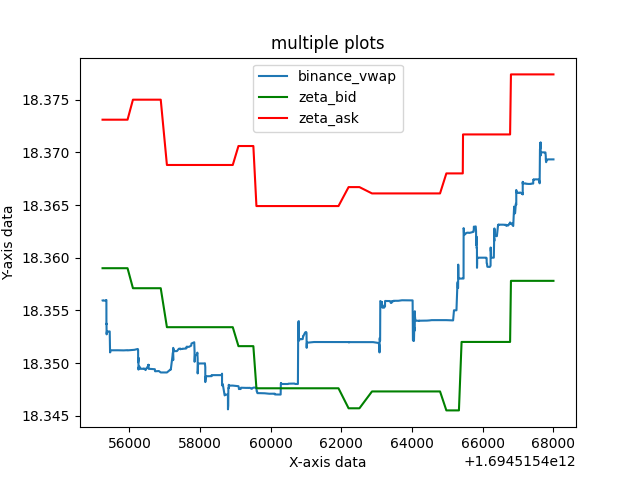

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt

# matplotlib plot 3 series fairs, bids, asks
fig, ax = plt.subplots()
x = [p["timestamp"] for p in prices]
plt.plot(x, [p["binance_vwap"] for p in prices], label="binance_vwap")
plt.plot(x, [p["bids"] for p in prices], "g-", label="zeta_bid")
plt.plot(x, [p["asks"] for p in prices], "r-", label="zeta_ask")

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title("multiple plots")
plt.show()